Uno de los métodos populares para aprender los conceptos básicos de deep learning es con el conjunto de datos MNIST. Es el "Hola mundo" en el aprendizaje profundo. El conjunto de datos contiene escritos a mano. numbers de 0 a 9 con un total de 60,000 10,000 muestras de entrenamiento y 28 28 muestras de prueba que ya están etiquetadas con un tamaño de XNUMX × XNUMX píxeles.

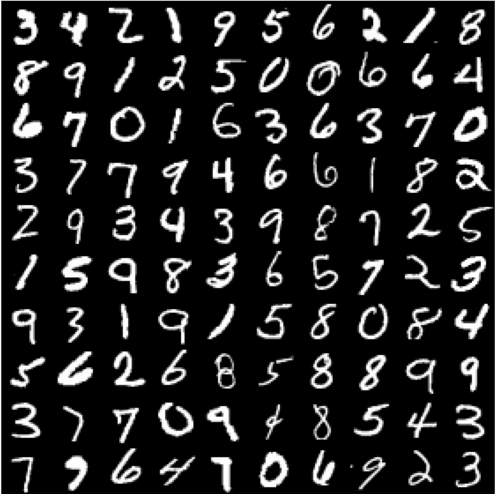



**Paso 1) Preprocesar los datos**

En el primer paso de este ejemplo de clasificación de PyTorch, cargará el conjunto de datos utilizando el módulo torchvision.

Antes de comenzar el proceso de entrenamiento, es necesario comprender los datos. Torchvision cargará el conjunto de datos y transformará las imágenes con los requisitos adecuados para la red, como la forma y la normalización de las imágenes.

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, models, transforms

# Esto se utiliza para transformar las imágenes a Tensor y normalizarlas.
transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=4,
                                         shuffle=True, num_workers=2)

testing = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

import matplotlib.pyplot as plt
import numpy as np

# Crear un iterador para train_loader
# Obtener imágenes de entrenamiento aleatorias
data_iterator = iter(train_loader)
images, labels = data_iterator.next()

# Trazar 4 imágenes para visualizar los datos
rows = 2
columns = 2
fig=plt.figure()
for i in range(4):
   fig.add_subplot(rows, columns, i+1)
   plt.title(classes[labels[i]])
   img = images[i] / 2 + 0.5     # esto es para desnormalizar la imagen
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

La función de transformación convierte las imágenes en tensor y normaliza el valor. La función torchvision.transforms.MNIST descargará el conjunto de datos (si no está disponible) en el directorio, configurará el conjunto de datos para entrenamiento si es necesario y realizará el proceso de transformación.

Para visualizar el conjunto de datos, utiliza data_iterator para obtener el siguiente lote de imágenes y etiquetas. Utilice matplot para trazar estas imágenes y su etiqueta adecuada. Como podéis ver debajo nuestras imágenes y sus etiquetas.

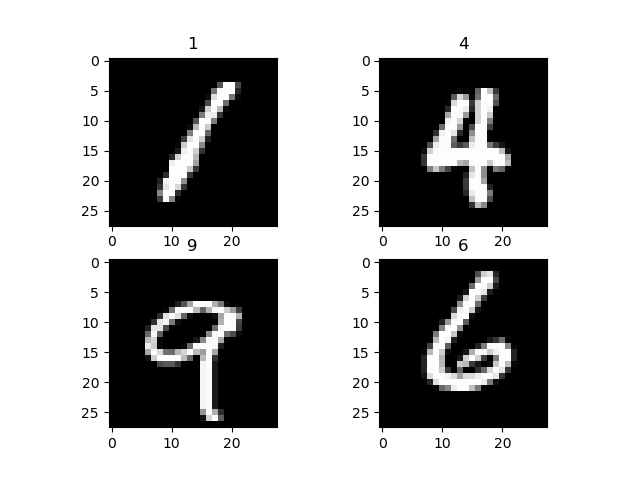

**Paso 2) Configuración del modelo de red**

Aquí presentamos la creación del modelo de red en PyTorch. Usaremos nn.Sequential para crear un modelo de secuencia en lugar de crear una subclase de nn.Module.

In [ ]:
import torch.nn as nn

# flatten the tensor into
class Flatten(nn.Module):
   def forward(self, input):
       return input.view(input.size(0), -1)

#sequential based model
seq_model = nn.Sequential(
           nn.Conv2d(1, 10, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Dropout2d(),
           nn.Conv2d(10, 20, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           Flatten(),
           nn.Linear(320, 50),
           nn.ReLU(),
           nn.Linear(50, 10),
           nn.Softmax(),
         )

net = seq_model
print(net)

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten()
  (8): Linear(in_features=320, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): Softmax(dim=None)
)


**Explicación de la red**



1.   La secuencia es que la primera capa es una capa Conv2D con una forma de entrada de 1 y una forma de salida de 10 con un tamaño de núcleo de 5.
2.   A continuación, tienes una capa MaxPool2D.
3.   Una función de activación de ReLU.
4.   Una capa de abandono para eliminar valores de baja probabilidad.
5.   Luego, un segundo Conv2d con la forma de entrada de 10 de la última capa y la forma de salida de 20 con un tamaño de kernel de 5.
6.   Siguiente una capa MaxPool2d.
7.   Función de activación ReLU.
8.   Después de eso, aplanarás el tensor antes de introducirlo en la capa Lineal.
9.   Linear Layer mapeará nuestra salida en la segunda capa Linear con la función de activación softmax.

**Paso 3) Entrena el modelo**

Antes de comenzar el proceso de entrenamiento, es necesario configurar el criterio y la función optimizadora.

Para el criterio, utilizará CrossEntropyLoss. Para el Optimizador, utilizará el SGD con una tasa de aprendizaje de 0.001 y un momentum de 0.9 como se muestra en el siguiente ejemplo de PyTorch.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

El proceso de avance tomará la forma de entrada y la pasará a la primera capa conv2d. Luego, desde allí, se introducirá en maxpool2d y finalmente se colocará en la función de activación de ReLU. El mismo proceso ocurrirá en la segunda capa conv2d. Después de eso, la entrada se reformará a (-1,320) y se introducirá en la capa fc para predecir la salida.

Ahora, comenzarás el proceso de entrenamiento. Recorrerá nuestro conjunto de datos 2 veces o con una epoch de 2 e imprimirá la pérdida actual en cada lote de 2000.

In [ ]:
for epoch in range(2):

# Establezca la pérdida de funcionamiento en cada epoch en cero
   running_loss = 0.0
# Enumeraremos el train loarder con índice inicial de 0
# para cada iteración (i) y los datos (tupla de entrada y etiquetas)
   for i, data in enumerate(train_loader, 0):
       inputs, labels = data

# Borrar el gradiente
       optimizer.zero_grad()

# Alimentar la entrada y adquirir la salida de la red
       outputs = net(inputs)

# Calcular la pérdida prevista y esperada.
       loss = criterion(outputs, labels)

# Calcular el gradiente
       loss.backward()

# Actualizar los parametros
       optimizer.step()

       # Imprimir estadísticas
       running_loss += loss.item()
       if i % 1000 == 0:
           print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 1000))
           running_loss = 0.0

En cada epoch, el enumerador obtendrá la siguiente tupla de entrada y las etiquetas correspondientes. Antes de enviar la entrada a nuestro modelo de red, debemos borrar el gradiente anterior. Esto es necesario porque después del proceso hacia atrás (proceso de retropropagación), el gradiente se acumulará en lugar de ser reemplazado. Luego, calcularemos las pérdidas de la producción prevista a partir de la producción esperada. Después de eso, haremos una retropropagación para calcular el gradiente y, finalmente, actualizaremos los parámetros.

Aquí está el resultado del proceso de formación.

```
[1, 	1] loss: 0.002
[1,  1001] loss: 2.302
[1,  2001] loss: 2.295
[1,  3001] loss: 2.204
[1,  4001] loss: 1.930
[1,  5001] loss: 1.791
[1,  6001] loss: 1.756
[1,  7001] loss: 1.744
[1,  8001] loss: 1.696
[1,  9001] loss: 1.650
[1, 10001] loss: 1.640
[1, 11001] loss: 1.631
[1, 12001] loss: 1.631
[1, 13001] loss: 1.624
[1, 14001] loss: 1.616
[2, 	1] loss: 0.001
[2,  1001] loss: 1.604
[2,  2001] loss: 1.607
[2,  3001] loss: 1.602
[2,  4001] loss: 1.596
[2,  5001] loss: 1.608
[2,  6001] loss: 1.589
[2,  7001] loss: 1.610
[2,  8001] loss: 1.596
[2,  9001] loss: 1.598
[2, 10001] loss: 1.603
[2, 11001] loss: 1.596
[2, 12001] loss: 1.587
[2, 13001] loss: 1.596
[2, 14001] loss: 1.603
```


**Paso 4) Prueba el modelo**

Después de entrenar nuestro modelo, debe probarlo o evaluarlo con otros conjuntos de imágenes.

Usaremos un iterador para test_loader y generará un lote de imágenes y etiquetas que se pasarán al modelo entrenado. La salida prevista se mostraráyed y compararlo con el resultado esperado.

In [ ]:
# Hacer un iterador desde test_loader
# Obtenga un lote de imágenes de entrenamiento
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

results = net(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure()
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

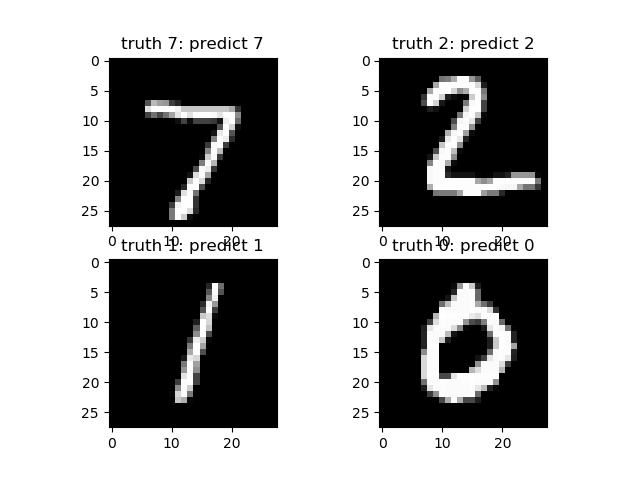